## 0. 데이터 불러오기

In [1]:
# 코랩 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

"""
header = 0 은 파일의 첫 번째 줄에 열 이름이 있음을 나타내며
delimiter = \t 는 필드가 탭으로 구분되는 것을 의미한다.
quoting = 3은 쌍따옴표를 무시하도록 한다.
"""
# QUOTE_MINIMAL (0), QUOTE_ALL (1),
# QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

# 레이블인 sentiment 가 있는 학습 데이터
train = pd.read_csv('/content/drive/MyDrive/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
# 레이블이 없는 데스트 데이터
test = pd.read_csv('/content/drive/MyDrive/testData.tsv', header=0, delimiter='\t', quoting=3)

In [3]:
print(train.shape)
print(test.shape)

(25000, 3)
(25000, 2)


## 1. EDA

In [4]:
train.head(5)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [5]:
test.head(5)

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [6]:
train.info()

# null값은 존재하지 않는다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [7]:
import numpy as np
print(len(np.unique(train['review'])))
print(np.sum(train['review'].value_counts() > 1))

# review 중 중복을 제외한 개수는 24904개이며
# 중복적으로 나오는 review는 92개이다.

# 오차범위내에서 크게 의미는 없는듯하다.

24904
92


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


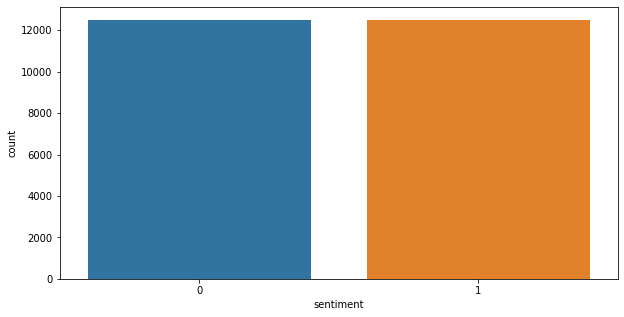

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import pathlib as Path
%matplotlib inline


fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(10, 5)
sns.countplot(train['sentiment'])
plt.show()

# 라벨의 분포는 1대1 인 것으로 보인다.

In [9]:
train_length = train['review'].apply(len)
train_length.head()

0    2304
1     948
2    2451
3    2247
4    2233
Name: review, dtype: int64

In [10]:
"plt.figure(figsize=(12,5))
plt.hist(train_length, bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log=Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')

# 길이분포를 히스토그램으로 파악

SyntaxError: ignored

In [ ]:
# 워드클라우드로 단어 시각화
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train['review']))
plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

In [11]:
# 각 리뷰 당 단어 개수(25000개 리뷰 학습 데이터)
train_word_counts = train['review'].apply(lambda x:len(x.split(' ')))
train_word_counts.head()

0    433
1    158
2    378
3    379
4    367
Name: review, dtype: int64

Text(0, 0.5, 'Number of reviews')

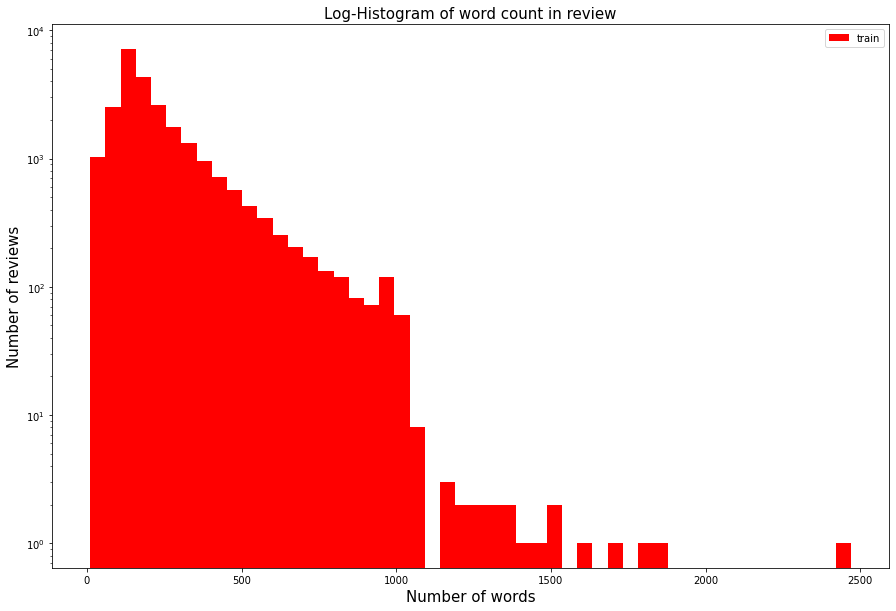

In [12]:
# 단어 수가 x개인 리뷰의 개수

plt.figure(figsize=(15,10))
plt.hist(train_word_counts, bins=50, facecolor='r', label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize = 15)
plt.ylabel('Number of reviews', fontsize=15)

## 2. 전처리

In [13]:
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

In [14]:
# 설치 및 버전확인
!pip3 show BeautifulSoup4

Name: beautifulsoup4
Version: 4.6.3
Summary: Screen-scraping library
Home-page: http://www.crummy.com/software/BeautifulSoup/bs4/
Author: Leonard Richardson
Author-email: leonardr@segfault.org
License: MIT
Location: /usr/local/lib/python3.8/dist-packages
Requires: 
Required-by: bs4, gdown, google


In [15]:
# review의 첫 번째 데이터의 HTML 태그 제거 
from bs4 import BeautifulSoup

example1 = BeautifulSoup(train['review'][0], "html5lib")
print(train['review'][0][:700])
example1.get_text()[:700]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [16]:
import re
# 정큐표현식을 활용해 영문자가 아니면 공백으로 치환 
letters_only = re.sub('[^a-zA-z]',' ',example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [17]:
# 토큰화 진행
# 소문자 변환
lower_case = letters_only.lower()

# 문자를 나눔

words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

## 불용어 제거

In [18]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords.words('english')[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [20]:
# stopwords 를 제거한 토큰들
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

## 어간 추출

In [21]:
# 포터 스태머의 사용 예
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

maximum
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [22]:
# 랭커스터 스태머의 사용 예
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
print(lancaster_stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(lancaster_stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(lancaster_stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(lancaster_stemmer.stem("run")))

maxim
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [23]:
# 처리 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [24]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]

# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

In [25]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 문자열 처리

In [28]:
def review_to_words(raw_review):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. Stopwords를 세트로 변환
    # 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return(' '.join(stemming_words))

In [29]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [30]:
# 첫 번째 리뷰를 대상으로 전처리 해줬던 내용을 전체 텍스트 데이터를 대상으로 처리한다.
# 전체 리뷰 데이터 수 가져오기
num_reviews = train['review'].size
num_reviews

25000

In [31]:
clean_train_reviews = []
for i in range(0, num_reviews):
     if (i + 1) % 5000 == 0 :  #실행이 잘되는지 확인하기 위해 5000개 실행될때마다 확인문구
         print('Review {} of {}'.format(i+1, num_reviews))
     clean_train_reviews.append(review_to_words(train['review'][i]))

%time train['review_clean'] = train['review'].apply(review_to_words)

Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Review 25000 of 25000
CPU times: user 51.5 s, sys: 721 ms, total: 52.2 s
Wall time: 52.4 s


In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# 튜토리얼과 다르게 파라미터 값을 수정
# 파라미터 값만 수정해도 캐글 스코어 차이가 많이 남
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 3),
                             max_features = 5000)
vectorizer

CountVectorizer(max_features=5000, min_df=2, ngram_range=(1, 3))

In [33]:
train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features.shape

# 25000개의 리뷰들에 5000개의 feature로 vectorizer 적용

(25000, 5000)

In [34]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

5000


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abandon',
 'abc',
 'abil',
 'abl',
 'abort',
 'abraham',
 'abrupt',
 'absenc',
 'absolut',
 'absolut love']

In [35]:
# 벡터화 된 feature를 확인해 봄
import numpy as np
dist = np.sum(train_data_features, axis=0)
    
for tag, count in zip(vocab, dist):
    print(count, tag)

# 전체 데이터의 counts를 모두 sum한 결과
pd.DataFrame(dist, columns=vocab)

[[ 288  125  562 ... 1331   89  161]] abandon


,abandon,abc,abil,abl,abort,abraham,abrupt,absenc,absolut,absolut love,...,young girl,young man,young peopl,young woman,younger,youth,zero,zombi,zombi movi,zone
0,288,125,562,1259,92,93,136,118,1850,93,...,199,233,92,236,504,364,390,1331,89,161


## random forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)

forest

RandomForestClassifier(n_jobs=-1, random_state=2018)

In [37]:
%time forest = forest.fit(train_data_features, train['sentiment'])

# 학습 진행

CPU times: user 1min 26s, sys: 117 ms, total: 1min 26s
Wall time: 59.4 s


In [38]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, train_data_features, \
    train['sentiment'], cv=10, scoring='roc_auc'))
score

CPU times: user 8.61 s, sys: 1.02 s, total: 9.64 s
Wall time: 7min 7s


0.922193088

In [39]:
clean_test_reviews = []
for i in range(0, num_reviews):
     if (i + 1) % 5000 == 0 :  #실행이 잘되는지 확인하기 위해 5000개 실행될때마다 확인문구
         print('Review {} of {}'.format(i+1, num_reviews))
     clean_test_reviews.append(review_to_words(test['review'][i]))

# 문자열 전처리 진행

Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Review 25000 of 25000


In [40]:
test_data_features = vectorizer.fit_transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

In [41]:
result = forest.predict(test_data_features)

# 예측값을 result에 저장

In [42]:
output = pd.DataFrame(data={"id":test["id"], "sentiment" : result, "review":test["review"]})
output    # kaggle score : 0.85360

# 데이터프레임 형성

,id,sentiment,review
0,"""12311_10""",0,"""Naturally in a film who's main themes are of ..."
1,"""8348_2""",0,"""This movie is a disaster within a disaster fi..."
2,"""5828_4""",0,"""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""",1,"""Afraid of the Dark left me with the impressio..."
4,"""12128_7""",0,"""A very accurate depiction of small time mob l..."
...,...,...,...
24995,"""2155_10""",0,"""Sony Pictures Classics, I'm looking at you! S..."
24996,"""59_10""",0,"""I always felt that Ms. Merkerson had never go..."
24997,"""2531_1""",0,"""I was so disappointed in this movie. I am ver..."
24998,"""7772_8""",1,"""From the opening sequence, filled with black ..."


In [43]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

12992


0    18996
1     6004
Name: sentiment, dtype: int64